In [25]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warnings
import warnings


warnings.filterwarnings("ignore")

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy


# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [26]:
# Data Augmentation and Generators with validation_split
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest",
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(data_dir, target_size=(150, 150), batch_size=32,
                                                    class_mode='categorical', subset='training')

validation_generator = train_datagen.flow_from_directory(data_dir, target_size=(150, 150), batch_size=32,
                                                         class_mode='categorical', subset='validation')

Found 2479 images belonging to 4 classes.
Found 617 images belonging to 4 classes.


In [29]:
# Imports
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Load and preprocess data
def load_images_from_directory(directory, target_size=(150, 150)):
    images = []
    labels = []
    label_map = {label: idx for idx, label in enumerate(os.listdir(directory)) if os.path.isdir(os.path.join(directory, label))}

    for label in label_map:
        label_dir = os.path.join(directory, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = tf.io.read_file(img_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, target_size) / 255.0  # Rescale
            images.append(img.numpy())
            labels.append(label_map[label])

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load and split data
data_dir = './Data'
images, labels = load_images_from_directory(data_dir)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Optional: Perform manual augmentation
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image

# Apply augmentation only on training images
X_train = np.array([augment_image(img).numpy() for img in X_train])

# Model Definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(256, (3, 3), activation='relu'),  # Additional layer
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Adding L2 regularization
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr, checkpoint])

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {test_accuracy:.4f}")


Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 36s 405ms/step - accuracy: 0.4743 - loss: 6.5549 - val_accuracy: 0.3532 - val_loss: 6.4089 - learning_rate: 1.0000e-04
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 34s 439ms/step - accuracy: 0.7270 - loss: 5.4766 - val_accuracy: 0.3677 - val_loss: 6.3607 - learning_rate: 1.0000e-04
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 35s 447ms/step - accuracy: 0.8515 - loss: 5.0078 - val_accuracy: 0.3823 - val_loss: 7.7417 - learning_rate: 1.0000e-04
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 35s 449ms/step - accuracy: 0.9072 - loss: 4.6587 - val_accuracy: 0.3968 - val_loss: 6.6349 - learning_rate: 1.0000e-04
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 36s 465ms/step - accuracy: 0.9414 - loss: 4.3304 - val_accuracy: 0.6452 - val_loss: 4.9352 - learning_rate: 1.0000e-04
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 35s 449ms/step - accuracy: 0.9556 - loss: 4.0514 - val_accuracy: 0.7548 - val_loss: 4.3879 - learning_rate: 1.0000e-04
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 37s 471ms/step - acc

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step


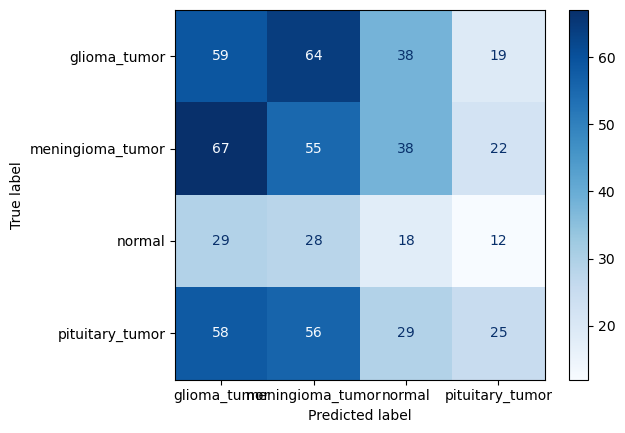

In [30]:
# Display Confusion Matrix
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap='Blues')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


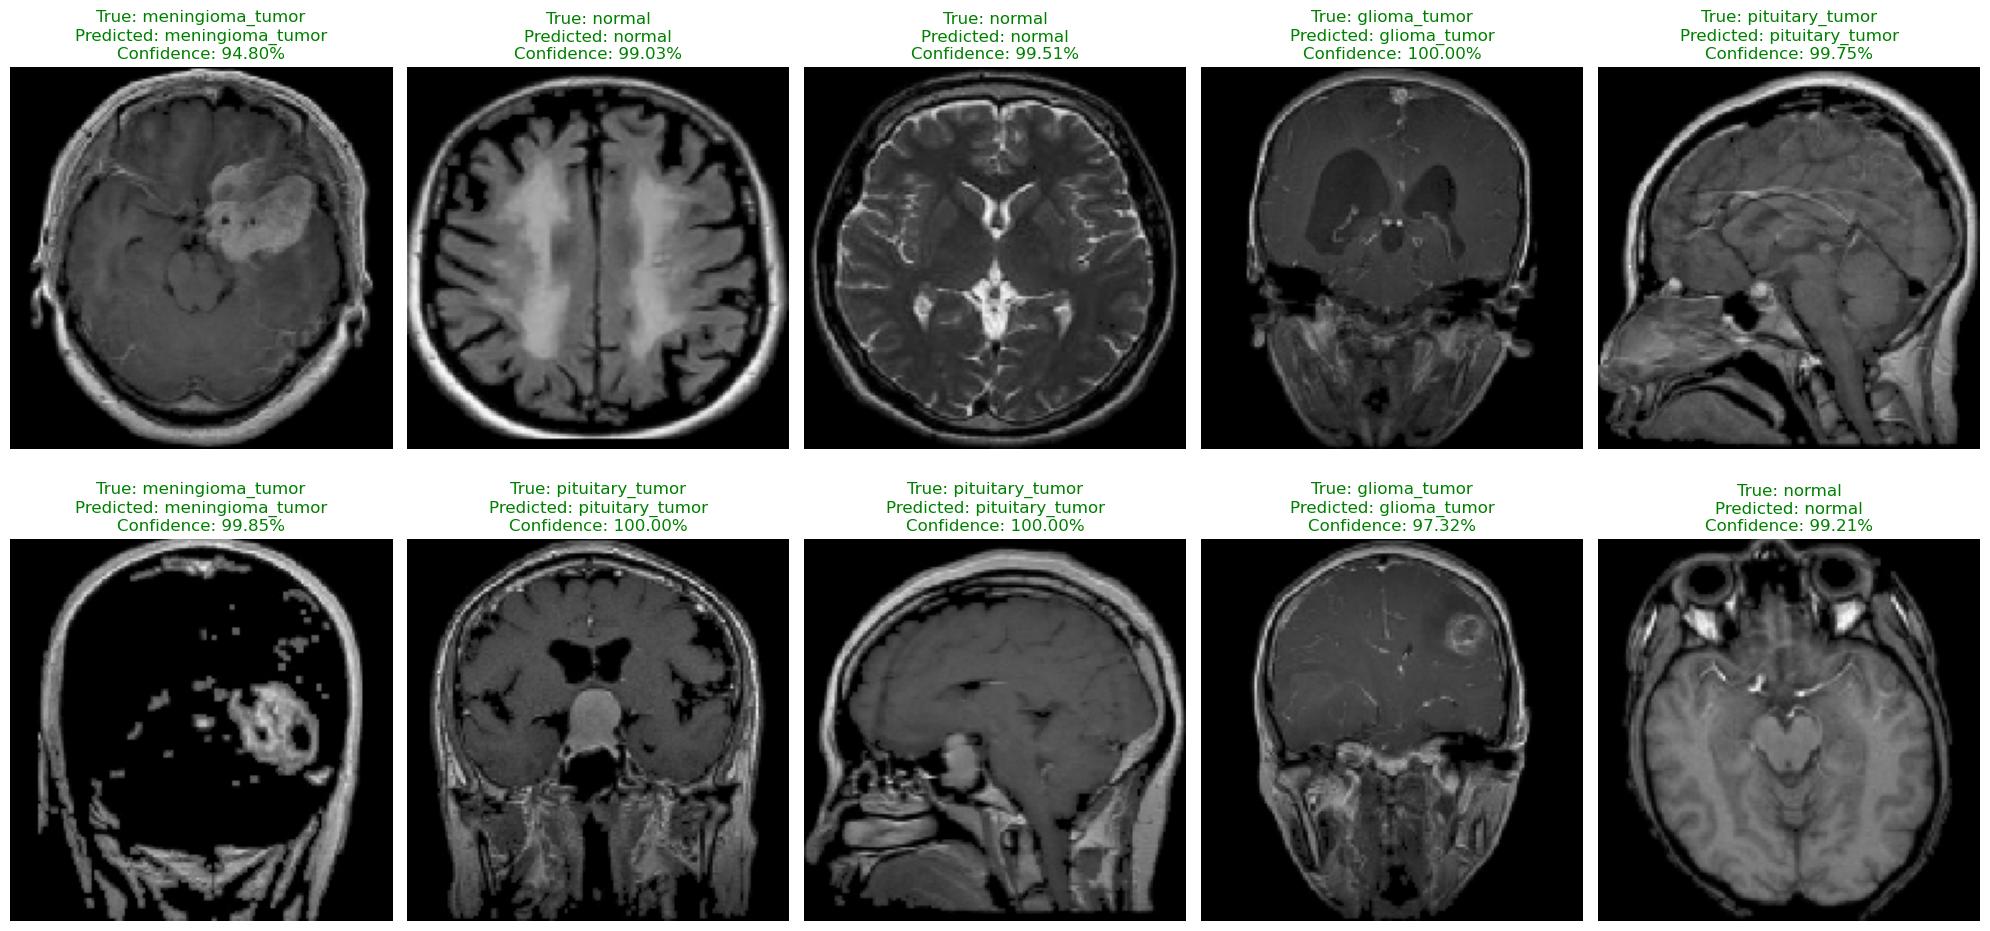

In [31]:
def display_predictions(generator, model, num_images=10):
    # Set up figure for display
    plt.figure(figsize=(20, 10))
    
    # Get a random sample of images from the generator
    for i in range(num_images):
        # Randomly pick an image index from the generator
        index = random.randint(0, generator.samples - 1)
        
        # Load the image and preprocess it
        img_path = generator.filepaths[index]
        img = load_img(img_path, target_size=(150, 150))
        img_array = img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction) * 100
        
        # Get true label
        true_class = generator.labels[index]
        class_labels = list(generator.class_indices.keys())
        
        # Plot the image
        plt.subplot(num_images // 5, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        
        # Add title with true label, predicted label, and confidence
        plt.title(f"True: {class_labels[true_class]}\n"
                  f"Predicted: {class_labels[predicted_class]}\n"
                  f"Confidence: {confidence:.2f}%", color="green")

    plt.tight_layout()
    plt.show()

# Call the function
display_predictions(validation_generator, model, num_images=10)